In [43]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


from scipy.special import logsumexp
from scipy.special import softmax
from scipy.special import betaln
from scipy.special import beta

from scipy.stats import multivariate_normal 
from scipy.stats import invwishart 

from sklearn import metrics
from scipy.special import psi, gammaln
from scipy.special import digamma,expit


In [44]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Derivation

## Mean Field 

Mean Field (Structured) Independence Simplifying Assumption
$$\begin{align}
    q(\boldsymbol{\pi},\boldsymbol{\phi},\mathbf{z},\mathbf{X}_H)& = 
        \underbrace{q(\boldsymbol{\pi})}_{\text{Dirichlet}}\quad
        \underbrace{q(\boldsymbol{\phi})}_{\text{Beta}}\quad
        \underbrace{q(\mathbf{z})}_{\text{Cat}}\quad
        \underbrace{q(\mathbf{X}_H)}_{\text{Bernoulli}}\\

        &=  q(\mathbf{z}, \mathbf{X}_H) \cdot
            \prod_K^K q(\boldsymbol{\pi}_k) q(\boldsymbol{\phi}_k)
\end{align}$$

Update Steps 

$$\begin{align}
    &\ln q(\boldsymbol{\phi},\boldsymbol{\pi}) = \Big\langle \ln p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}  + \text{const}\\\\
    
    &\ln q(\mathbf{z},\mathbf{X}_H) = \Big\langle \ln p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\boldsymbol{\phi},\boldsymbol{\pi})} + \text{const}
\end{align}$$

Posterior
$$
    p(\mathbf{X}_O,\mathbf{X}_H,\boldsymbol{\phi},\mathbf{z},\boldsymbol{\pi}) \propto p(\mathbf{X}_O,\mathbf{X}_H|\boldsymbol{\phi},\mathbf{z})p(\boldsymbol{\phi})p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi})
$$

## Update for model parameters $p(\mu,\pi)$

$$\begin{align}
    \ln q(\boldsymbol{\phi},\boldsymbol{\pi}) &= \Big\langle \ln p(\mathbf{z},\boldsymbol{\phi},\mathbf{X}_H,\mathbf{X}_O) \Big\rangle_{q(\mathbf{z})} + \text{const}\\\\

    &= \Big\langle \ln p(\mathbf{X}_O,\mathbf{X}_H|\boldsymbol{\phi}, \mathbf{z}) \Big\rangle_{q(\mathbf{z})} + 
       \Big\langle \ln p(\boldsymbol{\phi}) \Big\rangle_{q(\mathbf{z})} + 
        \Big\langle \ln p(\mathbf{z}|\boldsymbol{\pi})p(\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} +
       \text{const}\\\\

    &=  \underbrace{\Big\langle \ln p(\mathbf{X}_O,\mathbf{X}_H|\boldsymbol{\phi}, \mathbf{z}) \Big\rangle_{q(\mathbf{z})} + 
        \ln p(\boldsymbol{\phi})}_{\text{Terms containing $\boldsymbol{\phi}$}} + 
       \underbrace{
            \Big\langle \ln p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + 
            \ln p(\boldsymbol{\pi}) 
       }_{\text{\text{Terms containing $\boldsymbol{\pi}$}}} +
       \text{const}\\\\
\end{align}$$

#### Update Step for $q(\boldsymbol{\pi})$

$$\begin{align}
    \ln q(\boldsymbol{\pi}) &= \ln p(\boldsymbol{\pi}) + \Big\langle \ln p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \ln \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0) + \Big\langle \sum_n^N \ln p(z_n|\boldsymbol{\pi}) \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &= \ln \Big[ \frac{1}{B(\alpha_0)}\prod_k^K \pi_k^{\alpha_0 - 1} \Big] + \Big\langle \sum_n^N \sum_k^K \ln \pi_{k}^{z_{nk}} \Big\rangle_{q(\mathbf{z})} + \text{const} \\
       
    &= \underbrace{-\ln B(\alpha_0)}_{\text{Independent of $\pi$}} + \sum_k^K \ln \pi_k^{\alpha_0 - 1} +
       \Big\langle \sum_k^K \sum_n^N z_{nk}\ln \pi_{k} \Big\rangle_{q(\mathbf{z})} + \text{const} \\

    &=   \sum_k^K (\alpha_0 - 1) \ln \pi_k + \sum_k^K \sum_n^N \Big\langle z_{nk} \Big\rangle_{q(\mathbf{z})} \ln \pi_{k} + \text{const}, \quad -\ln B(\alpha_0) \text{ absorbed into const}\\

    &= \sum_k^K (\alpha_0 - 1) \ln \pi_k + \sum_k^K \sum_n^N r_{nk} \ln \pi_{k} + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 - 1) \ln \pi_k + \ln \pi_{k} \sum_n^N r_{nk} \Big] + \text{const}\\

    &= \sum_k^K \Big[ (\alpha_0 + N_k -1) \ln \pi_k  \Big] + \text{const}, \quad \text{where } N_k = \sum_n^N r_{nk} \\

    \implies & \boxed{q(\boldsymbol{\pi}) = \prod_k^K \pi_k^{\alpha_0 + N_k - 1} + \text{const} = \text{Dir}(\boldsymbol{\pi}|\boldsymbol{\alpha}_0 + N), \quad \text{where } N = [N_0,...,N_K]}\\
\end{align}$$

#### Update step for $q(\boldsymbol{\phi})$

$$\begin{align}
    \ln q(\boldsymbol{\phi}) &= \Big\langle \ln p(\mathbf{X}_H,\mathbf{X}_O|\boldsymbol{\phi}, \mathbf{z}) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)} + \ln p(\boldsymbol{\phi}) + \text{const}\\\\

    &= \sum_k^K \ln p(\boldsymbol{\phi}_k) + \Big\langle \sum_n^N \sum_k^K \ln p(\mathbf{x}^n_{O},\mathbf{x}^n_{H}|\boldsymbol{\phi}_k)^{z_{nk}} \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}  + \text{const}\\\\

    &= \sum_k^K \ln p(\boldsymbol{\phi}_k) + \Big\langle \sum_n^N \sum_k^K z_{nk} \cdot \ln p(\mathbf{x}^n_{O},\mathbf{x}^n_{H}|\boldsymbol{\phi}_k) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}  + \text{const}\\\\

    &= \sum_k^K \Bigg[ \ln p(\boldsymbol{\phi}_k) + \sum_n^N \Big\langle z_{nk} \cdot \ln p(\mathbf{x}^n_{O},\mathbf{x}^n_{H}|\boldsymbol{\phi}_k) \Big\rangle_{q(\mathbf{z},\mathbf{X}_H)}   \Bigg]+ \text{const}\\\\ 

    \implies & \ln q(\boldsymbol{\phi}) = \sum_k^K \ln q(\boldsymbol{\phi}_k)
\end{align}$$

Hence with $\boldsymbol{\phi} = \{\boldsymbol{\mu}\}$,
$$\begin{align}
    \ln q(\boldsymbol{\mu}_k) &= \ln p(\boldsymbol{\mu}_k) + \sum_n^N \Big\langle z_{nk} \cdot \ln p(\mathbf{x}^n_{O},\mathbf{x}^n_{H}|\boldsymbol{\mu}_k) \Big\rangle_{q(z_n,\mathbf{x}^n_H)} + \text{const}\\\\

    &= \ln p(\boldsymbol{\mu}_k) + \sum_n^N \Big\langle z_{nk} \Big\rangle_{q_(z_n)} \cdot  \Big\langle \ln p(\mathbf{x}^n_{O},\mathbf{x}^n_{H}|\boldsymbol{\mu}_k) \Big\rangle_{q(\mathbf{x}^n_H | z_n)} + \text{const}\\\\

    &= \ln p(\boldsymbol{\mu}_k) +  \sum_n^N r_{nk} \cdot   \Big\langle \ln p(\mathbf{x}^n_{O},\mathbf{x}^n_{H}|\boldsymbol{\mu}_k) \Big\rangle_{q(\mathbf{x}^n_H | z_n)} + \text{const}\\\\

    &= \ln \mathcal{Beta}(\boldsymbol{\mu}_k | \mathbf{a}_{0},\mathbf{b}_{0}) + 
        \sum_n^N r_{nk} \cdot \Big\langle \ln \mathcal{Bern}(\mathbf{x}^n_{O},\mathbf{x}^n_{H}|\boldsymbol{\mu}_k) \Big\rangle_{q(\mathbf{x}^n_H | z_n)} + \text{const}\\\\

    &= \sum_d^D \ln\mathcal{Beta}(\mu_{k,d}|a_{0,d}, b_{0,d}) + 
         \sum_n^N r_{nk} \cdot \Big\langle \ln \mathcal{Bern}(\mathbf{x}^{n}_{O},\mathbf{x}^{n}_{H}|\mu_{k}) \Big\rangle_{q(\mathbf{x}^n_H | z_n)} + \text{const}\\\\


    &=  \sum_d^D (a_{0,d} - 1)\ln\mu_{k,d} + (b_{0,d} - 1)\ln(1 - \mu_{k,d}) + 
        \sum_n^N r_{nk} \cdot \Big\langle 
            [x^{n}_O, x^{n}_H] \ln\mu_{k} + (1 - [x^{n}_O, x^{n}_H])\ln(1 - \mu_{k}) 
        \Big\rangle_{q(\mathbf{x}^n_H | z_n)} 
        + \text{const}\\\\

    &= \sum_d^D (a_{0,d} - 1)\ln\mu_{k,d} + (b_{0,d} - 1)\ln(1 - \mu_{k,d}) + 
       \sum_d^D \sum_n^N r_{nk} \cdot \Big\langle 
            x_d^n \ln\mu_{k,d} + (1 - x_d^n)\ln(1 - \mu_{k,d}) 
        \Big\rangle_{q(\mathbf{x}^n_H | z_n)} + \text{const}\\\\

    &= \sum_d^D (a_{0,d} - 1)\ln\mu_{k,d} + (b_{0,d} - 1)\ln(1 - \mu_{k,d}) + 
       \sum_d^D \sum_n^N r_{nk} \cdot \Big[
            \big\langle x_d^n \big\rangle_{k}\ln\mu_{k,d} + 
            (1 - \big\langle x_d^n \big\rangle_{k})\ln(1 - \mu_{k,d})
       ] + \text{const}\\\\
    
    \implies \ln q(\mu_{k,d}) &= (a_{0,d} - 1)\ln\mu_{k,d} + (b_{0,d} - 1)\ln(1 - \mu_{k,d}) + 
                \sum_n^N r_{nk} \big\langle x_d^n \big\rangle_{k} \ln\mu_{k,d} + 
                \sum_n^N r_{nk} (1 - \big\langle x_d^n \big\rangle_{k})\ln(1 - \mu_{k})
            + \text{const}\\\\

    &= \Big(a_{0,d} + \sum_n^N r_{nk} \big\langle x_d^n \big\rangle_{k}\ln\mu_{k,d} - 1\Big)\ln\mu_{k,d} + 
        \Big(b_{0,d} +  \sum_n^N r_{nk} (1 - \big\langle x_d^n \big\rangle_{k}) - 1\Big)\ln(1 - \mu_{k,d}) + \text{const}
\end{align}$$
This is Beta form. Hence 
$$\begin{align}
    q(\mu_{k,d}) &= \mathcal{Beta}(\mu_{k,d}|a_{k,d}, b_{k,d})\\
        &a_{k,d} = a_{0,d} + \sum_n^N r_{nk} \big\langle x_d^n \big\rangle_{k}\\
        &b_{k,d} = b_{0,d} + \sum_n^N r_{nk} (1 - \big\langle x_d^n \big\rangle_{k})
\end{align}$$
Where for $d \in H$ 
$$
    \langle x_{d} \rangle_{q(\mathbf{x}^n_H | z_n=k)} = \frac{\exp \Big({\langle \ln \mu_{k,d}\rangle}\Big)}{\exp \Big({\langle \ln \mu_{k,d} \rangle}\Big) + \exp \Big({\langle \ln(1 - \mu_{k,d}) \rangle} \Big)} =
    \frac{\exp \Big({\psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d})} \Big )}{\exp\Big({\psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d})}\Big) + \exp\Big({\psi(b_{k,d}) - \psi(a_{k,d} + b_{k,d})}\Big)}
$$

#### Update step for $q(\mathbf{z},\mathbf{X}_H)$
Noting that 
$$
    q(\mathbf{z},\mathbf{X}_H) = \underbrace{q(\mathbf{z})}_{(1)}\underbrace{q(\mathbf{X}_H|\mathbf{z})}_{(2)}
$$

We have
$$\begin{align}
    (2) \quad \ln q(\mathbf{X}_H|\mathbf{z}) &= \ln q(\mathbf{X}_H,\mathbf{z}) + \text{const}\\\\

    &= \Big\langle \ln p(\mathbf{X}_O,\mathbf{X}_H,\boldsymbol{\mu},\boldsymbol{\pi}) \Big\rangle_{q(\mu,\pi)} + \text{const}\\\\

     &= \Big\langle \ln p(\mathbf{X}_O,\mathbf{X}_H|\boldsymbol{\mu},\mathbf{z}) \Big\rangle_{q(\mu)} + 
       \underbrace{ \Big\langle \ln p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle_{q(\pi)} + 
        \ln p(\boldsymbol{\mu}) + \ln p(\boldsymbol{\pi})}_{\text{Independent of }\mathbf{X}_H} + 
    \text{const}\\\\

    &= \Big\langle \ln p(\mathbf{X}_O,\mathbf{X}_H|\boldsymbol{\mu},\mathbf{z}) \Big\rangle_{q(\mu)} + 
        \text{const}\\\\

    &= \Big\langle \sum_n^N \sum_k^K z_{nk} \cdot \ln p(\mathbf{x}^n_O,\mathbf{x}^n_H|\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)} + \text{const}\\\\

    &= \sum_n^N  \Bigg\langle \sum_k^K z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\mu}_k) + z_{nk}\ln p(\mathbf{x}^n_{H}|\mathbf{x}^n_{O},\boldsymbol{\mu}_k)\Bigg\rangle_{q(\mu)} + \text{const}\\\\

    \implies & \ln q(\mathbf{x}^n_H|z_n) = \Bigg\langle \sum_k^K z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\mu}_k) + z_{nk}\ln p(\mathbf{x}^n_{H}|\mathbf{x}^n_{O},\boldsymbol{\mu}_k)\Bigg\rangle_{q(\mu)} + \text{const}\\\\

    &= \underbrace{\Bigg\langle \sum_k^K z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\mu}_k)\Bigg\rangle_{q(\mu)}}_{\text{Independent of }\mathbf{x}^n_H} + 
        \Bigg\langle \sum_k^K z_{nk}\ln p(\mathbf{x}^n_{H}|\mathbf{x}^n_{O},\boldsymbol{\mu}_k)\Bigg\rangle_{q(\mu)} + \text{const}\\\\

        &= \sum_k^K \Bigg\langle  z_{nk}\ln p(\mathbf{x}^n_{H}|\mathbf{x}^n_{O},\boldsymbol{\mu}_k)\Bigg\rangle_{q(\mu)} + \text{const}\\\\

    \implies \ln q(\mathbf{x}^n_H|z_n=k) &=  \Bigg\langle \ln p(\mathbf{x}^n_{H}|\mathbf{x}^n_{O},\boldsymbol{\mu}_k)\Bigg\rangle_{q(\mu)} + \text{const}\\\\

    &= \Bigg\langle \ln\mathcal{Bern}(\mathbf{x}^n_{H}|\mathbf{x}^n_{O},\boldsymbol{\mu}_k)\Bigg\rangle_{q(\mu)} + \text{const} =  \Bigg\langle \ln \mathcal{Bern}(\mathbf{x}^n_{H}|\boldsymbol{\mu}_k)\Bigg\rangle_{q(\mu)} + \text{const}
        ,\qquad \text{Since for Bernouilli } \mathbf{x}_H \perp \mathbf{x}_O \\\\

    &= \Bigg\langle \sum_{d\in H} x_d^n \ln \mu_{k,d} + (1 - x^n_d)\ln(1 - \mu_{k,d}) \Bigg\rangle_{q(\mu)} + \text{const}\\\\

    &= \sum_{d\in H} \Bigg[ x_d^n \Big\langle \ln \mu_{k,d} \Big\rangle_{q(\mu)} + 
        (1 - x^n_d) \Big\langle \ln (1-\mu_{k,d})\Big\rangle_{q(\mu)} \Bigg] +
        \text{const}\\\\

    \implies  \ln q(x_d^n | z_n =k) &= x_d^n \Big\langle \ln \mu_{k,d} \Big\rangle_{q(\mu)} + 
        (1 - x^n_d) \Big\langle \ln (1-\mu_{k,d})\Big\rangle_{q(\mu)}  + \text{const}\\\\

    &= x_d^n \Big( \psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d}) \Big) + (1 - x_d^n)\Big(  \psi(b_{k,d}) - \psi(a_{k,d} + b_{k,d}) \Big)

\end{align}$$

  
And  
$$\begin{align}
    (1) \quad \ln q(z_n) &= \ln q(z_n, \mathbf{x}^n_H) - \ln q(\mathbf{x}_H^n) + \text{const}\\\\

    &= \Big\langle \sum_k^K z_{nk} \ln \boldsymbol{\pi}_k + \sum_k^K z_{nk} \ln p(\mathbf{x}_O^n,\mathbf{x}_H^n|\boldsymbol{\mu}_k)  \Big\rangle_{q(\mu,\pi)} - 
        \Big\langle \sum_k^K z_{nk} \ln p(\mathbf{x}^n_H|\mathbf{x}^n_O,\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)} + \text{const}\\\\

    &= \Bigg\langle  
            \sum_k^K z_{nk}\ln \boldsymbol{\pi}_k + 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\mu}_k) + 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_H|\mathbf{x}^n_O,\boldsymbol{\mu}_k) 
       \Bigg\rangle_{q(\mu,\pi)} -
       \Bigg\langle 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_H|\mathbf{x}^n_O,\boldsymbol{\mu}_k)
       \Bigg\rangle_{q(\mu)} + \text{const}\\\\

    &= \Bigg\langle  
            \sum_k^K z_{nk}\ln \boldsymbol{\pi}_k + 
            \sum_k^K z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\mu}_k) 
       \Bigg\rangle_{q(\mu,\pi)} + \text{const}\\\\

    &= \sum_k^K \Bigg[ 
        \Big\langle  z_{nk}\ln \boldsymbol{\pi}_k \Big\rangle_{q(\pi)} + 
        \Big\langle z_{nk} \ln p(\mathbf{x}^n_O|\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)}
       \Bigg] + \text{const}\\\\

    \implies \ln q(z_n=k) &= \Big\langle \ln \boldsymbol{\pi}_k \Big\rangle_{q(\pi)} + \Big\langle\ln p(\mathbf{x}^n_O|\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)} + \text{const}\\\\

    &= \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) + \Big\langle \ln \mathcal{Bern}(\mathbf{x}^n_O|\boldsymbol{\mu}_k) \Big\rangle_{q(\mu)} + \text{const}\\\\

    &= \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) +
       \Big\langle 
             \sum_{d \in O} x_{d}^n \ln (1-\mu_{k,d}) + (1-x_{d}^n)\ln(1-\mu_{k,d})
       \Big\rangle_{q(\mu)} + \text{const}\\\\

    &= \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) +
        \sum_{d \in O} x_{d}^n \Big\langle\ln\mu_{k,d}\Big\rangle + (1-x_{d}^n)\Big\langle\ln(1-\mu_{k,d})\Big\rangle
        + \text{const}\\\\

    &= \psi(\alpha_k) - \psi\Big(\sum_{k'}\alpha_{k'}\Big) +
        \sum_{d \in O} 
            x_{d}^n \Big(\psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d})\Big) + 
            (1-x_d^n)\Big(\psi(b_{k,d}) - \psi(a_{k,d} + b_{k,d}\Big)) + 
        \text{const}


\end{align}$$

$$\begin{align}
    \text{ELBO} =\quad& \Big\langle \ln p(\boldsymbol{\pi},\boldsymbol{\mu},\mathbf{z},\mathbf{X}_O,\mathbf{X}_H) \Big\rangle_{q} - 
                \Big\langle \ln q(\boldsymbol{\pi},\boldsymbol{\mu},\mathbf{z},\mathbf{X}_H) \Big\rangle_{q}\\\\

                =\quad& \Big\langle \ln p(\boldsymbol{\pi}) \Big\rangle - \Big\langle \ln q(\boldsymbol{\pi}) \Big\rangle + 
                  \Big\langle \ln p(\boldsymbol{\mu}) \Big\rangle - \Big\langle \ln q(\boldsymbol{\mu}) \Big\rangle + 
                  \Big\langle \ln p(\mathbf{z}|\boldsymbol{\pi}) \Big\rangle - \Big\langle \ln q(\mathbf{z}) \Big\rangle + 
                  \Big\langle \ln p(\mathbf{X}_O, \mathbf{X}_H|\mathbf{z},\boldsymbol{\mu}) \Big\rangle - \Big\langle \ln q(\mathbf{X}_H|\mathbf{z}) \Big\rangle\\\\


                = \quad& 
                    \ln B(\boldsymbol{\alpha}) - \ln B(\boldsymbol{\alpha}_0) + \sum_k^K (\alpha_{0,k} - \alpha_k)(\psi(\alpha_k) - \psi(\sum_{k'}\alpha_{k'}) ) \quad + \\
                    & \sum_k^K \sum_d^D \Big[ 
                        (a_{0,d} - a_{k,d})(\psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d})) +
                        (b_{0,d} - b_{k,d})(\psi(b_{k,d}) - \psi(a_{k,d} + b_{k,d})) + 
                        \ln B(a_{k,d},b_{k,d}) - 
                        \ln B(a_{0,d},b_{0,d})
                    \Big] + \\
                    & \sum_n^N \sum_k^K \Bigg[ r_{nk} (\psi(\alpha_k) - \psi(\sum_{k'}\alpha_{k'})) - r_{nk}\ln r_{nk} \Bigg] + \\
                    & \sum_n^N \sum_k^K \sum_d^D r_{nk} \Bigg[ 
                        \langle x_{d}^n \rangle\Big(\psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d})\Big)  + 
                        (1 - \langle x_{d}^n \rangle)\Big(\psi(b_{k,d}) - \psi(a_{k,d} + b_{k,d})\Big)
                    \Bigg] - \\
                    & \sum_n^N\sum_k^K r_{nk} \Big[ \sum_d^D \tau^n_{d,k} \ln \tau^n_{d,k}  + (1 - \tau^n_{d,k})\ln(1 - \tau^n_{d,k})\Big]
                
\end{align}$$
Where
$$
    \langle x_{d}^n \rangle = \begin{cases} 
                                    \tau^n_{d,k}, \quad \text{if } d \in H\\
                                    x_d^n, \quad \text{if } d \in O
                              \end{cases}
$$
And
$$
    \tau^n_{d,k} = \frac{\exp \Big({\psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d})} \Big )}{\exp\Big({\psi(a_{k,d}) - \psi(a_{k,d} + b_{k,d})}\Big) + \exp\Big({\psi(b_{k,d}) - \psi(a_{k,d} + b_{k,d})}\Big)}
$$

# 2 Implementation

$$
    B(\alpha) = \frac{\prod_k^K \Gamma(\alpha_k)}{\Gamma(\sum_k^K \alpha_k)}
$$

In [45]:
α_0 = np.full(10, 1, dtype=np.float64)
psi(α_0)

array([-0.57721566, -0.57721566, -0.57721566, -0.57721566, -0.57721566,
       -0.57721566, -0.57721566, -0.57721566, -0.57721566, -0.57721566])

In [82]:
def b_func(α):
    return np.sum(gammaln(α), axis=0) - gammaln(α.sum())

def log_B_beta(a, b):
    """elementwise log Beta(a,b); a,b shape (...)."""
    return gammaln(a) + gammaln(b) - gammaln(a + b)

In [83]:
def kl_pi(α,α_0):
    return b_func(α) - b_func(α_0) + np.sum((α_0 - α) * (psi(α) - psi(α.sum())))

def kl_mu(a_0,b_0,a,b):
    Elog_mu  = psi(a) - psi(a + b)
    Elog_1mu = psi(b) - psi(a + b)
    return (np.sum(log_B_beta(a, b) - log_B_beta(a_0, b_0)) +
            np.sum((a_0 - a) * Elog_mu) +
            np.sum((b_0 - b) * Elog_1mu))

def kl_z(R,α):
    return np.sum( R * (psi(α) - psi(α.sum()))[None,:] - (R * np.log(R + 1e-12)))

def kl_XH(miss, R, hat_x, a, b):
    N,D=miss.shape
    _,K = R.shape

    tau = np.zeros((N, D, K))
    for d in range(D):
        if np.any(miss[:, d]):
            tau[miss[:, d], d, :] = hat_x[:, d][None, :]

    eps = 1e-10

    N, D, K = tau.shape
    E_mu = a / (a + b + eps)  # (K, D)

    tau = np.transpose(tau, (0, 2, 1))  # shape (N, K, D)
    E_mu = np.transpose(E_mu, (0, 1))   # shape (K, D)

    log_tau = np.log(tau + eps)
    log_1_tau = np.log(1 - tau + eps)
    log_mu = np.log(E_mu[None, :, :] + eps)
    log_1_mu = np.log(1 - E_mu[None, :, :] + eps)

    kl_elem = tau * (log_tau - log_mu) + (1 - tau) * (log_1_tau - log_1_mu)  # (N, K, D)
    kl_per_z = np.sum(kl_elem, axis=2)  # (N, K)

    kl_total = np.sum(R * kl_per_z)  # scalar

    return kl_total 

def elbo_X_obs(X, R, a, b):
    """
    Expected log p(X_obs | z, mu).
    X: (N,D) with np.nan for missing.
    """
    obs = ~np.isnan(X)
    X_obs  = np.where(obs, X, 0.0)
    Xc_obs = np.where(obs, 1.0 - X, 0.0)

    Elog_mu  = psi(a) - psi(a + b)    # (K,D)
    Elog_1mu = psi(b) - psi(a + b)    # (K,D)

    ll = X_obs @ Elog_mu.T + Xc_obs @ Elog_1mu.T  # (N,K)
    return np.sum(R * ll)


def compute_elbo(X,R,a_0,b_0,a,b,α_0,α,hat_x):
    miss = np.isnan(X)

    elbo = (
        kl_pi(α,α_0) + 
        kl_mu(a_0,b_0,a,b) + 
        kl_z(R,α) + 
        elbo_X_obs(X, R, a, b) -
        kl_XH(miss,R,hat_x,a,b)
    )

    return elbo

In [48]:
def update_Θ(X,R,a_0,b_0,a,b,K):
    N,D = X.shape

    miss_mask = np.isnan(X)
    obs_mask = ~miss_mask
    # X_obs = np.where(obs_mask,X,0.0)

    a_new = np.zeros((K,D))
    b_new = np.zeros((K,D))

    exp_x = expit(digamma(a) - digamma(b))

    for k in range(K):
       
        x = (exp_x[k] * miss_mask) + np.nan_to_num(X * obs_mask, nan=0)

        a_new[k,:] = a_0[k,:] + (R[:,k].T @ x)
        b_new[k,:] = b_0[k,:] + (R[:,k].T @ (1 - x))

    return a_new,b_new
    

In [49]:
def bernoulli_logprob_with_missing(X, a, b):

    psi_ab  = digamma(a + b)
    elog_mu  = digamma(a) - psi_ab # (K,D)
    elog_1mu = digamma(b) - psi_ab # (K,D)

    hat_x = expit(digamma(a) - digamma(b))

    obs  = ~np.isnan(X)        
    miss = ~obs

    X_obs1  = np.where(obs, X, 0.0) # (N,D)
    X_obs0 = np.where(obs, 1.0 - X, 0.0) # (N,D)

    lp_obs = X_obs1  @ elog_mu.T  +  X_obs0 @ elog_1mu.T   # (N,K)

    miss_weight = hat_x * elog_mu + (1.0 - hat_x) * elog_1mu   # (K,D)
    lp_miss = miss.astype(float) @ miss_weight.T  # (N,K)

    return lp_obs + lp_miss

In [50]:
'''
    Collapsed version
'''
def bernoulli_logprob_with_missing(X, a, b):
    psi_ab = digamma(a + b)
    elog_mu   = digamma(a) - psi_ab      
    elog_1mu  = digamma(b) - psi_ab     

    obs = ~np.isnan(X)
    X_obs   = np.where(obs, X, 0.0)       
    Xc_obs  = np.where(obs, 1.0 - X, 0.0) 

    hat_x = expit(digamma(a) - digamma(b))

    # (N,D) @ (D,K) -> (N,K)
    return X_obs @ elog_mu.T + Xc_obs @ elog_1mu.T, hat_x

In [51]:
def update_z(X,dataLogProb,α,πs,K,mode=0):
    N,D = X.shape

    R = np.zeros((N,K))

    α_sum = psi(np.sum(α))

    for k in range(K):
        logprior = psi(α[k]) - α_sum

        R[:,k] = dataLogProb[:,k].copy()

        if mode == 0:
            R[:,k] += logprior
        elif mode == 1:
            R[:,k] += np.log(πs[k])

    log_norm = logsumexp(R,axis=1,keepdims=True)

    R = np.exp(R - log_norm)

    loglik = np.sum(log_norm) / N

    return R,loglik   

In [52]:
def update_π(R,α_0):
    αs = α_0 + np.sum(R, axis=0) 

    return αs

In [93]:
def meanfield_vi(X,K,mode=0,max_iters=100,tol=1e-4):
    N,D = X.shape

    α_0 = np.full(K, 1, dtype=np.float64)
    a_0  = np.full((K, D), 1) # Beta
    b_0  = np.full((K, D), 1) # Beta

    a = a_0.copy()+ rng.gamma(1.0, 0.1, size=(K, D))
    b = b_0.copy()+ rng.gamma(1.0, 0.1, size=(K, D))
    α = α_0.copy()
    πs = rng.dirichlet(alpha=α)

    loglikes = []
    elbos = []

    for t in range(max_iters):
        dataLogProb,hat_x = bernoulli_logprob_with_missing(X, a,b)
        R,loglike = update_z(X,dataLogProb,α,πs,K,mode=mode)

        α = update_π(R,α_0)
        a,b = update_Θ(X,R,a_0,b_0,a,b,K)

        loglikes.append(loglike)

        elbo = compute_elbo(X,R,a_0,b_0,a,b,α_0,α,hat_x)

        elbos.append(elbo)

        if t > 1 and np.abs(elbos[t] - elbos[t-1]) < tol:
            break

    return R, a, b, α, loglikes,elbos

# 3 Evaluation

In [54]:
def impute_x(X, R, a, b, rng=None):
    rng = np.random.default_rng(rng)
    N, D = X.shape
    K = R.shape[1]
    miss = np.isnan(X)

    hat_x = expit(digamma(a) - digamma(b))  # (K,D)

    z = np.array([rng.choice(K, p=R[n]) for n in range(N)])
    # z = np.argmax(R, axis=1)

    X_imp = X.copy()
    for n in range(N):
        k = z[n]
        miss_n = miss[n]
        if np.any(miss_n):
            X_imp[n, miss_n] = rng.binomial(1, hat_x[k, miss_n])
    return X_imp, z

In [55]:
def impute_ppd(X, R, a, b, rng=None):
    rng = np.random.default_rng(rng)
    N, D = X.shape
    miss = np.isnan(X)

    mu_mean = a / (a + b)    
    p = R @ mu_mean                

    X_imp = X.copy()
    X_imp[miss] = rng.binomial(1, p[miss])
    return X_imp

## 3.1 Prepare Data

In [56]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

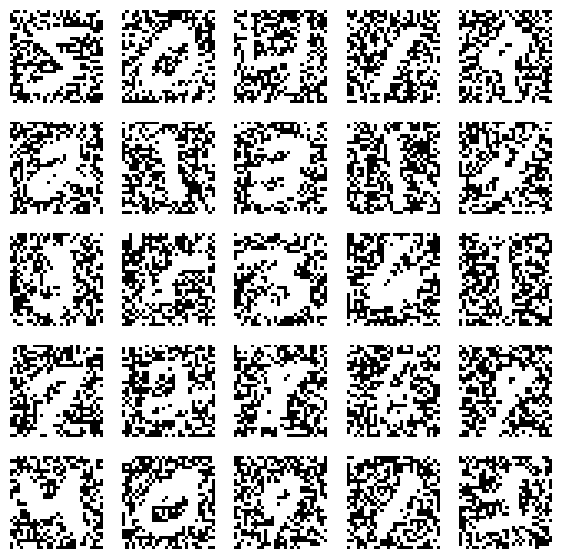

In [57]:
import random
X_mnist_cover1 = np.empty_like(X_mnist_train, dtype='f')
X_mnist_cover1[:] = X_mnist_train
for i in range(0,len(X_mnist_cover1)):
    indices = random.sample(range(0,784), 784//2)
    X_mnist_cover1[i][indices] = np.nan

figure = plt.figure(figsize=(7, 7))
rows, cols= 5, 5
for k in range(25):
    img = X_mnist_cover1[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

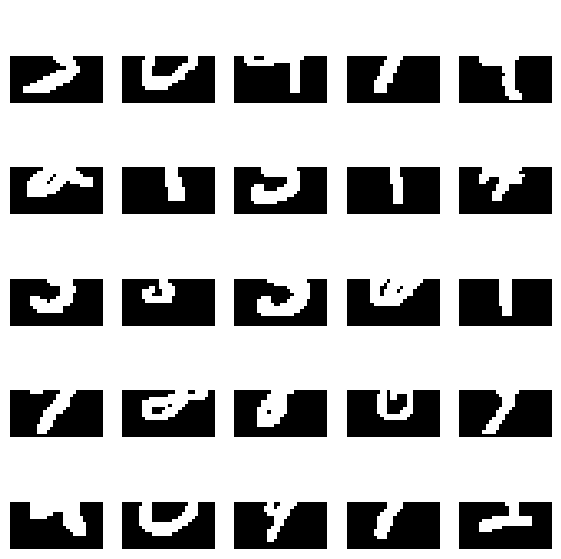

In [58]:
X_mnist_cover2 = np.empty_like(X_mnist_train, dtype='f')
X_mnist_cover2[:] = X_mnist_train
X_mnist_cover2[:, 0: int(784//2)] = np.nan

figure = plt.figure(figsize=(7, 7))
rows, cols= 5, 5
for k in range(25):
    img = X_mnist_cover2[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

## 3.2 Evaluation

In [94]:
R, a, b, α, loglikes,elbos = meanfield_vi(X_mnist_cover1, 10)
zs = np.argmax(R,axis=1)
metrics.adjusted_rand_score(Y_mnist_train, zs)

0.37166758247991466

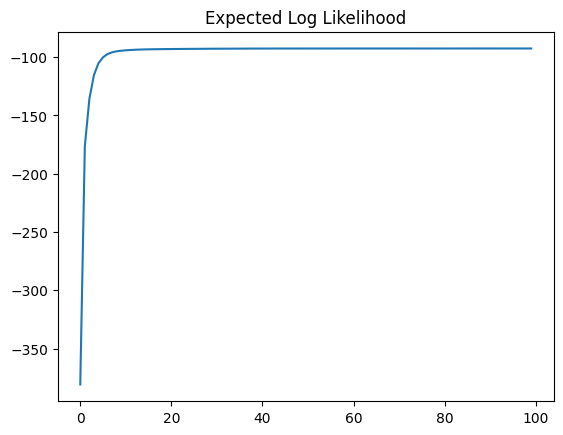

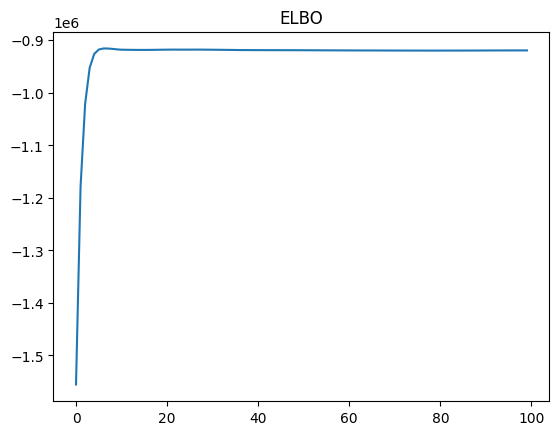

In [97]:
plt.plot(loglikes)
plt.title("Expected Log Likelihood")
plt.show()

plt.plot(elbos)
plt.title("ELBO")
plt.show()

Predict missing pixels

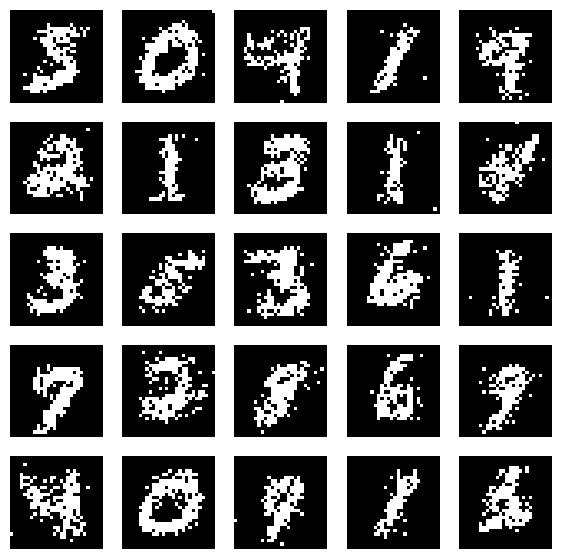

In [78]:
X_imp, z = impute_x(X_mnist_cover1,R,a,b)
figure = plt.figure(figsize=(7, 7))
rows, cols= 5, 5
for k in range(25):
    img = X_imp[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

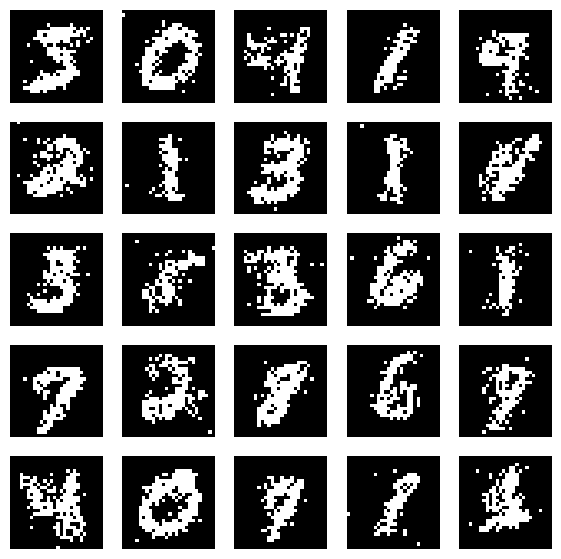

In [80]:
X_imp= impute_ppd(X_mnist_cover1,R,a,b)
figure = plt.figure(figsize=(7, 7))
rows, cols= 5, 5
for k in range(25):
    img = X_imp[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

In [85]:
R, a, b, α, loglikes = meanfield_vi(X_mnist_cover1, 10,mode=1)
zs = np.argmax(R,axis=1)
metrics.adjusted_rand_score(Y_mnist_train, zs)

0.3999546965473337

---

0.3016483201983157

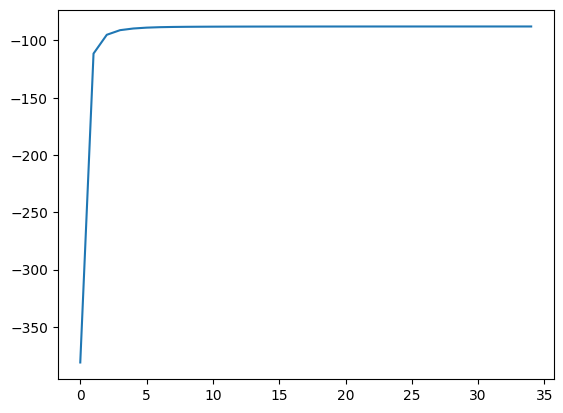

In [81]:
R, a, b, α, loglikes = meanfield_vi(X_mnist_cover2, 10)
zs = np.argmax(R,axis=1)
plt.plot(loglikes)
metrics.adjusted_rand_score(Y_mnist_train, zs)

In [84]:
R, a, b, α, loglikes = meanfield_vi(X_mnist_cover2, 10,mode=1)
zs = np.argmax(R,axis=1)
metrics.adjusted_rand_score(Y_mnist_train, zs)

0.2646045733660196